<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/Assignment_02_v1_Experiments_5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>






<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 02 - Part 1
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Imports

In [ ]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version and Keras Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


## Mount Google Drive to Colab environment

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## EDA Functions

In [ ]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [ ]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [ ]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [ ]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [ ]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


## Review Labels 

In [ ]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


## Plot Subset of Examples

In [ ]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [ ]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

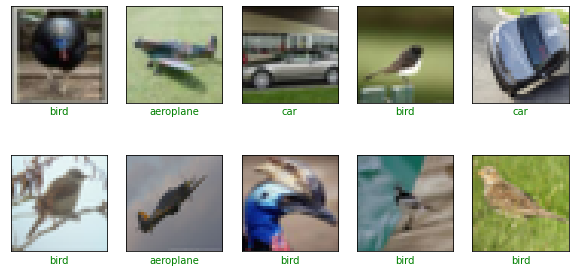

In [ ]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

## Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [ ]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [ ]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [ ]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [ ]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

print(x_train_norm.shape, x_valid_norm.shape, x_test_norm.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


##Experiment 5: Experiment 2 with regularization 
https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/

In [ ]:
from time import perf_counter 
from keras import regularizers
from keras.layers.core import Dropout

#### Model 5.2 

Same as Model 2 with regularization

In [ ]:
model_5_2 = Sequential()
model_5_2.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_2.add(layers.Dense(units = 100, activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model_5_2.add(layers.Dense(units = 250, activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model_5_2.add(layers.Dense(units = 150, activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model_5_2.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 100)               307300    
                                                                 
 dense_1 (Dense)             (None, 250)               25250     
                                                                 
 dense_2 (Dense)             (None, 150)               37650     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 371,710
Trainable params: 371,710
Non-trainable params: 0
_________________________________________________________________


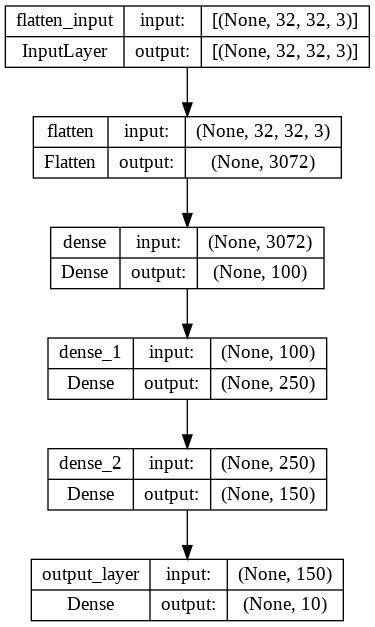

In [ ]:
keras.utils.plot_model(model_5_2, "CIFAR_model.png", show_shapes=True) 

In [ ]:
## Compile

model_5_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 
time = perf_counter()

history_5_2 = model_5_2.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_2.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 6s 4ms/step - loss: 2.5778 - accuracy: 0.3029 - val_loss: 2.0430 - val_accuracy: 0.3186
Epoch 2/200
704/704 [==============================] - 2s 4ms/step - loss: 1.9937 - accuracy: 0.3376 - val_loss: 1.9465 - val_accuracy: 0.3438
Epoch 3/200
704/704 [==============================] - 3s 4ms/step - loss: 1.9354 - accuracy: 0.3501 - val_loss: 1.9430 - val_accuracy: 0.3546
Epoch 4/200
704/704 [==============================] - 3s 4ms/step - loss: 1.9044 - accuracy: 0.3597 - val_loss: 1.9296 - val_accuracy: 0.3452
Epoch 5/200
704/704 [==============================] - 3s 4ms/step - loss: 1.8977 - accuracy: 0.3630 - val_loss: 1.9720 - val_accuracy: 0.3304
Epoch 6/200
704/704 [==============================] - 3s 4ms/step - loss: 1.8960 - accuracy: 0.3633 - val_loss: 2.0159 - val_accuracy: 0.3186


In [ ]:
time_5_2 = perf_counter() - time
print(time_5_2)

19.708389046999997


In [ ]:
## Evaluate

model_5_2 = tf.keras.models.load_model("DNN_model_5_2.h5")
print(f"Test acc: {model_5_2.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.9048 - accuracy: 0.3491
Test acc: 0.349


#### Model 5.2.1

Same as Model 2 with bais regularization L2

In [ ]:
from keras.regularizers import l2

model_5_21 = Sequential()
model_5_21.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_21.add(layers.Dense(units = 100, activation = "relu", bias_regularizer=l2(0.01)))
model_5_21.add(layers.Dense(units = 250, activation = "relu", bias_regularizer=l2(0.01)))
model_5_21.add(layers.Dense(units = 150, activation = "relu", bias_regularizer=l2(0.01)))
model_5_21.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_21.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_3 (Dense)             (None, 100)               307300    
                                                                 
 dense_4 (Dense)             (None, 250)               25250     
                                                                 
 dense_5 (Dense)             (None, 150)               37650     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 371,710
Trainable params: 371,710
Non-trainable params: 0
_________________________________________________________________


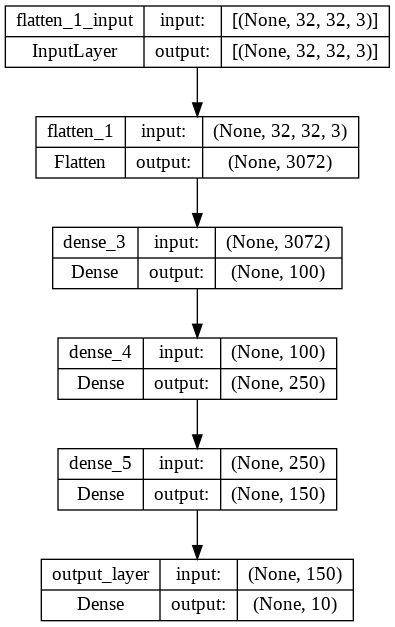

In [ ]:
keras.utils.plot_model(model_5_21, "CIFAR_model.png", show_shapes=True) 

In [ ]:
## Compile

model_5_21.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 
time = perf_counter()

history_5_21 = model_5_21.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_21.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 4ms/step - loss: 1.8684 - accuracy: 0.3194 - val_loss: 1.8084 - val_accuracy: 0.3496
Epoch 2/200
704/704 [==============================] - 3s 4ms/step - loss: 1.7054 - accuracy: 0.3849 - val_loss: 1.7486 - val_accuracy: 0.3738
Epoch 3/200
704/704 [==============================] - 3s 5ms/step - loss: 1.6298 - accuracy: 0.4141 - val_loss: 1.6500 - val_accuracy: 0.4014
Epoch 4/200
704/704 [==============================] - 2s 4ms/step - loss: 1.5747 - accuracy: 0.4378 - val_loss: 1.6423 - val_accuracy: 0.4140
Epoch 5/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5388 - accuracy: 0.4500 - val_loss: 1.6112 - val_accuracy: 0.4200
Epoch 6/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5092 - accuracy: 0.4594 - val_loss: 1.5738 - val_accuracy: 0.4284
Epoch 7/200
704/704 [==============================] - 3s 4ms/step - loss: 1.4838 - accuracy: 0.4694 - val_loss: 1.5281 - val_accuracy: 0.4508

In [ ]:
time_5_21 = perf_counter() - time
print(time_5_21)

41.55504983799999


In [ ]:
## Evaluate

model_5_21 = tf.keras.models.load_model("DNN_model_5_21.h5")
print(f"Test acc: {model_5_21.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.4777 - accuracy: 0.4758
Test acc: 0.476


#### Model 5.2.2 - BEST MODEL 2, tied with 5.2.3

Same as Model 5.2.1 with bais regularization L2, updated nodes (550, 300, 250)

In [ ]:
from keras.regularizers import l2

model_5_22 = Sequential()
model_5_22.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_22.add(layers.Dense(units = 550, activation = "relu", bias_regularizer=l2(0.01)))
model_5_22.add(layers.Dense(units = 300, activation = "relu", bias_regularizer=l2(0.01)))
model_5_22.add(layers.Dense(units = 250, activation = "relu", bias_regularizer=l2(0.01)))
model_5_22.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_22.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_6 (Dense)             (None, 550)               1690150   
                                                                 
 dense_7 (Dense)             (None, 300)               165300    
                                                                 
 dense_8 (Dense)             (None, 250)               75250     
                                                                 
 output_layer (Dense)        (None, 10)                2510      
                                                                 
Total params: 1,933,210
Trainable params: 1,933,210
Non-trainable params: 0
_________________________________________________________________


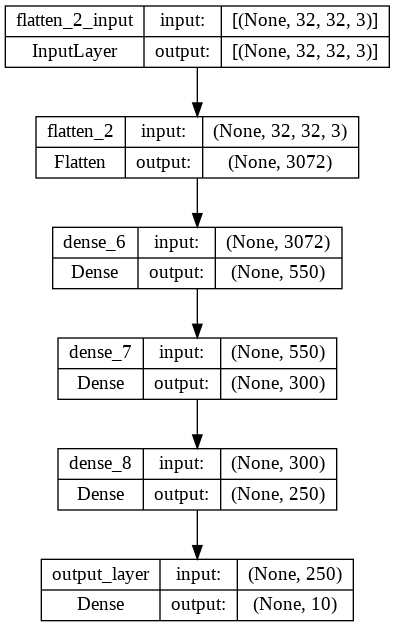

In [ ]:
keras.utils.plot_model(model_5_22, "CIFAR_model.png", show_shapes=True) 

In [ ]:
## Compile

model_5_22.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 
time = perf_counter()

history_5_22 = model_5_22.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_22.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 4ms/step - loss: 1.8791 - accuracy: 0.3178 - val_loss: 1.8036 - val_accuracy: 0.3552
Epoch 2/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6943 - accuracy: 0.3902 - val_loss: 1.6486 - val_accuracy: 0.4086
Epoch 3/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6039 - accuracy: 0.4260 - val_loss: 1.5770 - val_accuracy: 0.4328
Epoch 4/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5423 - accuracy: 0.4472 - val_loss: 1.5716 - val_accuracy: 0.4442
Epoch 5/200
704/704 [==============================] - 3s 4ms/step - loss: 1.4941 - accuracy: 0.4619 - val_loss: 1.5838 - val_accuracy: 0.4308
Epoch 6/200
704/704 [==============================] - 3s 4ms/step - loss: 1.4585 - accuracy: 0.4823 - val_loss: 1.5168 - val_accuracy: 0.4686
Epoch 7/200
704/704 [==============================] - 3s 4ms/step - loss: 1.4356 - accuracy: 0.4878 - val_loss: 1.5283 - val_accuracy: 0.4550

In [ ]:
time_5_22 = perf_counter() - time
print(time_5_22)

46.71091010799998


In [ ]:
## Evaluate

model_5_22 = tf.keras.models.load_model("DNN_model_5_22.h5")
print(f"Test acc: {model_5_22.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.4243 - accuracy: 0.5029
Test acc: 0.503


#### Model 5.2.3 - BEST MODEL 2, tied with 5.2.2

Same as Model 5.2.2 with dropout - 0.1 + output activation = sigmoid

In [ ]:
from keras.regularizers import l2

model_5_23 = Sequential()
model_5_23.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_23.add(layers.Dense(units = 550, activation = "relu", bias_regularizer=l2(0.01)))
model_5_23.add(Dropout(0.1))
model_5_23.add(layers.Dense(units = 300, activation = "relu", bias_regularizer=l2(0.01)))
model_5_23.add(Dropout(0.1))
model_5_23.add(layers.Dense(units = 250, activation = "relu", bias_regularizer=l2(0.01)))
model_5_23.add(Dropout(0.1))
model_5_23.add(layers.Dense(name = "output_layer", units = 10, activation = "sigmoid"))

model_5_23.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 3072)              0         
                                                                 
 dense_12 (Dense)            (None, 550)               1690150   
                                                                 
 dropout (Dropout)           (None, 550)               0         
                                                                 
 dense_13 (Dense)            (None, 300)               165300    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_14 (Dense)            (None, 250)               75250     
                                                                 
 dropout_2 (Dropout)         (None, 250)              

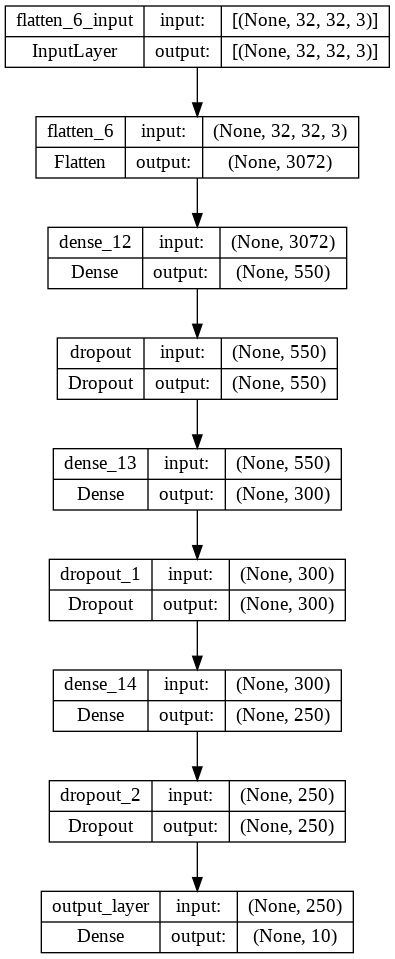

In [ ]:
keras.utils.plot_model(model_5_23, "CIFAR_model.png", show_shapes=True) 

In [ ]:
## Compile

model_5_23.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 
time = perf_counter()

history_5_23 = model_5_23.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_23.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 4s 4ms/step - loss: 1.9399 - accuracy: 0.2910 - val_loss: 1.7871 - val_accuracy: 0.3508
Epoch 2/200
704/704 [==============================] - 3s 4ms/step - loss: 1.7710 - accuracy: 0.3599 - val_loss: 1.7081 - val_accuracy: 0.3748
Epoch 3/200
704/704 [==============================] - 3s 4ms/step - loss: 1.7053 - accuracy: 0.3900 - val_loss: 1.6370 - val_accuracy: 0.4052
Epoch 4/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6649 - accuracy: 0.4047 - val_loss: 1.6038 - val_accuracy: 0.4224
Epoch 5/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6337 - accuracy: 0.4111 - val_loss: 1.5983 - val_accuracy: 0.4286
Epoch 6/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6060 - accuracy: 0.4255 - val_loss: 1.6006 - val_accuracy: 0.4296
Epoch 7/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5805 - accuracy: 0.4310 - val_loss: 1.5857 - val_accuracy: 0.4240

In [ ]:
time_5_23 = perf_counter() - time
print(time_5_23)

72.83173408599998


In [ ]:
## Evaluate

model_5_23 = tf.keras.models.load_model("DNN_model_5_23.h5")
print(f"Test acc: {model_5_23.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4349 - accuracy: 0.4880
Test acc: 0.488
